Alfred Wisana
c14210177

In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Klasifikasi Segi 4 Untuk Membededakan bentuk segi 4 berdasarkan sudut pada object

In [44]:

def classify_quadrilateral(approx):
    (x, y, w, h) = cv2.boundingRect(approx)
    aspect_ratio = w / float(h)
    aspect_ratio = round(aspect_ratio,2)
    if aspect_ratio==3.41 and aspect_ratio==0.49:
        return "Ellipse"
    
    if 0.95 <= aspect_ratio <= 1.05:
        return "Square"
    else:
        sides = []
        for i in range(4):
            sides.append(np.linalg.norm(approx[i] - approx[(i + 1) % 4]))

        sides = np.array(sides)
        opposite_sides_equal = np.isclose(sides[0], sides[2], atol=0.1) and np.isclose(sides[1], sides[3], atol=0.1)
        all_sides_equal = np.isclose(sides[0], sides[1], atol=0.1) and np.isclose(sides[1], sides[2], atol=0.1) and np.isclose(sides[2], sides[3], atol=0.1)

        cosines = []
        for i in range(4):
            cos = angle_cos(approx[i], approx[(i + 1) % 4], approx[(i + 2) % 4])
            cosines.append(cos)
        
        cosines = np.sort(cosines)
        
        if all_sides_equal:
            return "Rhombus"
        elif opposite_sides_equal:
            if np.allclose(cosines, [0, 0, 0, 0], atol=0.1):
                return "Rectangle"
            else:
                if aspect_ratio==0.49:
                    return "Oval"
                else:
                    return "Pararelogram"
        else:
            if aspect_ratio==3.41:
                return "Oval"
            else:
                return "Trapezoid"

def angle_cos(p0, p1, p2):
    d1, d2 = (p0 - p1).flatten(), (p2 - p1).flatten()
    return np.dot(d1, d2) / (np.linalg.norm(d1) * np.linalg.norm(d2))

In [73]:
def detect_shapes(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply GaussianBlur to reduce noise and improve edge detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Perform edge detection
    edged = cv2.Canny(blurred, 50, 150)

    
    text_area_start = (gray.shape[1] - 220, 0)
    text_area_end = (gray.shape[1], gray.shape[0])
    # Find contours in the edged image
    contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    shape_len = 0
    shape_dict={
        "Triangle":0,
        "Oval":0,
        "Circle":0,
        "Square":0,
        "Rectagle":0,
        "Trapezoid":0,
        "Pararelogram":0,
        "Hexagon":0,
        "Pentagon":0,
        "Unknown":0,
        "Pie":0,
        "Ellipse":0

    }
    # Loop over the contours
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if x >= text_area_start[0] and y >= text_area_start[1] and (x + w) <= text_area_end[0] and (y + h) <= text_area_end[1]:
            # This contour is within the masked area, so skip it
            continue
        # Compute the center of the contour
        
        # Compute the center of the contour
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX, cY = 0, 0

        # Approximate the contour
        approx = cv2.approxPolyDP(contour, 0.04 * cv2.arcLength(contour, True), True)

        # Determine the shape
        shape = "Unknown"
        if len(approx) == 3:
            shape = "Triangle"
            shape_len+=1
            shape_dict[shape]+=1
        elif len(approx) == 4:
            shape = classify_quadrilateral(approx)
            shape_len+=1
            shape_dict[shape]+=1


            # Untuk lebih dari segi 4 akan diguanakn berdasarkan circularity dari object 
        else:
            # Compute contour properties for more complex shapes
            area = cv2.contourArea(contour)
            perimeter = cv2.arcLength(contour, True)
            circularity = 0
            if perimeter != 0.0:
                circularity = 4 * np.pi * (area / perimeter**2)
            
            mask = np.zeros_like(gray)
            cv2.drawContours(mask, [contour], -1, 255, -1)
            masked_image = cv2.bitwise_and(gray, mask)

            # Calculate the percentage of circle completion
            total_pixels = np.sum(mask / 255)
            circle_pixels = np.sum(masked_image / 255)
            completion_ratio = circle_pixels / total_pixels

            if circularity < 0.7 :
                shape ="Pie"
                shape_len+=1
                shape_dict[shape]+=1

            elif 0.85 < circularity < 1.2:
                shape = "Circle"
                shape_len+=1
                shape_dict[shape]+=1

            else:
                # Fit an ellipse to the contour
                ellipse = cv2.fitEllipse(contour)
                (center, axes, orientation) = ellipse
                major_axis_length = max(axes)
                minor_axis_length = min(axes)
                eccentricity = np.sqrt(1 - (minor_axis_length / major_axis_length) ** 2)
                
                # Determine the shape
                shape = "Unknown"
                if eccentricity > 0.8:  # Empirical threshold for distinguishing circle from oval
                    shape = "Oval"
                    shape_len+=1
                    shape_dict[shape]+=1

                else:
                    # Check for 3/4 circle completion
                    mask = np.zeros_like(gray)
                    cv2.drawContours(mask, [contour], -1, 255, -1)
                    masked_image = cv2.bitwise_and(gray, mask)

                    # Calculate the percentage of circle completion
                    total_pixels = np.sum(mask / 255)
                    circle_pixels = np.sum(masked_image / 255)
                    completion_ratio = circle_pixels / total_pixels

                    # Define a threshold for approximately 3/4 circle completion
                    if 0.7 < completion_ratio < 0.85:
                        shape = "Three-Fourth Circle"
                    else:
                        if perimeter != 0.0:
                            circularity = 4 * np.pi * (area / (perimeter * perimeter))
                        if len(approx) == 5 and circularity > 0.75 and circularity < 0.8:
                            shape = "Pentagon"
                            shape_len+=1
                            shape_dict[shape]+=1

                        elif len(approx) == 6 and circularity > 0.8 and circularity < 0.85:
                            shape = "Hexagon"
                            shape_len+=1
                            shape_dict[shape]+=1

                        else:
                            shape ="Unknown"
                            shape_len+=1
                            shape_dict[shape]+=1

                
        if shape != "Unknown":
        # Draw the contour and the name of the shape on the image
            cv2.drawContours(image, [contour], -1, (100, 100, 200), 2)
            cv2.putText(image, shape, (cX-25, cY-35), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    

    return shape_len,image,shape_dict

Shape Detected in the image = 20
Shape Detected for Each Shape
Detected Triangle = 1
Detected Oval = 2
Detected Circle = 12
Detected Square = 1
Detected Hexagon = 1
Detected Pie = 3


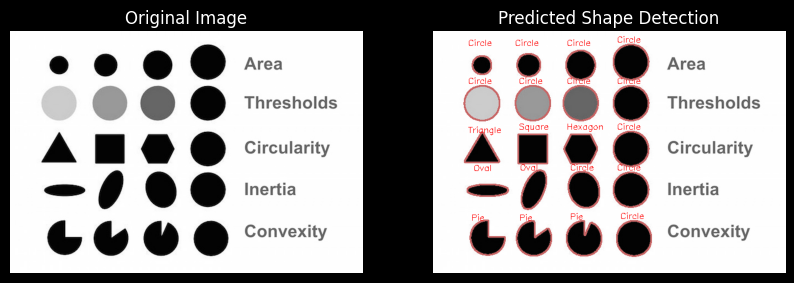

In [75]:
# Load an image
image_path = "BlobTest.jpg"  # Replace with your image path
image = cv2.imread(image_path)
image_temp = image.copy()

shape,output_image,shape_dict = detect_shapes(image_temp)
print(f"Shape Detected in the image = {shape}")# Display the output image

print("Shape Detected for Each Shape")
for shape_name,shape_len in shape_dict.items():
    if shape_len !=0:
        print(f"Detected {shape_name} = {shape_len}")

# print(shape_dict)
plt.figure(figsize=(10, 10))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')


plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title("Predicted Shape Detection")
plt.axis('off')
plt.show()